### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 8
### Due: Saturday, Apr 12th at 11.59pm CT
---

## Problem 1

1. Use the following code snippet to read in SDSS galaxy color data.
<!--```
from astroML.datasets import fetch_sdss_galaxy_colors
data = fetch_sdss_galaxy_colors()
```-->

`data = np.load('../hw_data/hw8_data_1.npy')`

This is a structured numpy array. Find and print all of the column names. Using the data, create arrays of $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create arrays of redshift and the spectral class. How many regular galaxies and how many quasars are in this sample?


2. Make a scatter plot of $(u-g)$ versus $(g-r)$, color coding by galaxy or quasar class. The plot should include appropriate axis labels and a legend. Set `xlim` between -0.5 and 2.5, and `ylim` between -0.5 and 1.5.


3. Stack all colors and the redshift into a data matrix, $X$. Create a target label array that has $0$ for a regular galaxy and $1$ for a quasar. Perform a train-test split, taking $20\%$ of the data for testing.


4. Create a compact `for` loop that iterates over the fitting of a Gaussian Naive Bayes classification algorithm to successively more features of the data. Within the loop, compute and plot an ROC curve. The end result should be a plot showing ROC curves for GNB classification with more and more features of the data, with appropriate axis labels and a legend. Use `xlim` between 0 and 0.01. Which feature seems to make the classification trivially easy? *Note: `predict_proba` returns an array with as many columns as classes. You've labeled quasars as $1$, so for the ROC curve you must make sure to access the relevant quasar probability-- you can find this by accessing the **classes_** attribute of the estimator.*


5. Repeat (4) for Quadratic Discriminant Analysis. 


6. Let's try classification with GMM Bayes. Restrict the training and testing to be just on the $4$ colors. Iterate now over number of components in the GMM Bayes fit up to $10$, plotting ROC curves for all, and find the number of components that gives the best performance.


7. Repeat (6) for $K$-nearest neighbor classification, looping over number of neighbors between 5 and 100 in steps of 10. Find the number that gives the best performance. 


8. Repeat (6) for Decision Tree classification, looping over the maximum tree depth between 1 and 10. Find the number that gives the best performance. 


9. Finally, plot the ROC curves for GNB, QDA, and the best-performing GMMBayes, KNN, and DT classification algorithms, all using just the 4 colors. What is the overall best-performing classifier? 


10. Make a 2-panel plot, showing in the left panel the color-coded training data in $(u-g)$ versus $(g-r)$ (similar to item 2 above), and in the right panel the same features of the testing data color coded by their predicted class from the tuned best-performing classifier. 

## Problem 2

The first few steps of this problem are the same as the previous problem.


1. Read in the same galaxy color data used above. Slice the data array to only take every other 10th row. From this reduced data volume, create arrays of $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create arrays of redshift and the spectral class. 


2. We're going to make classification pretty tough for our deep neural network. Make a scatter plot of $(r-i)$ versus $(i-z)$, color coding by galaxy or quasar class. Notice how much more difficult the visual discrimination is compared to $(u-g)$ versus $(g-r)$. The plot should include appropriate axis labels and a legend.


3. Stack the $(r-i)$ and $(i-z)$ colors into a data matrix, $X$. Create a target label array that has $0$ for a regular galaxy and $1$ for a quasar. Perform a train-test split, taking $20\%$ of the data for testing. Set the `random_state` in your train-test split to be `42` for reproducibility (and easy comparison with my solutions).


4. Scale your training and testing data to prepare it for the DNN. 


5. Train scikit-learn's multi-layer perceptron classifier with ReLU activation, stochastic gradient descent, two hidden layers of respective sizes of $5$ and $2$, and using `max_iter=1000`, and `random_state=42`. As with classifiers in last week's homework, plot an ROC curve that shows the network's performance on the scaled testing data. 


6. Now let's optimize the hyperparameters of your network. You will use `GridSearchCV` with the following hyperparameters for the network:

```
parameters = {'solver': ['lbfgs', 'sgd', 'adam'], 
              'hidden_layer_sizes': [(2,2), (5,5), (5,2), (5,5,5)], 
              'activation': ['relu', 'tanh'], 
              'random_state': [42], 'max_iter': [1000]}
```

Remember that you can utilize all availables cores on your machine with `n_jobs=-1`. Print out the classification score for the training data, and the best parameters obtained by the cross validation.


7. Fit a new DNN using the best hyperparameters obtained in (6), and make a plot that has ROC curves for this new network and your original network. Let the x and y axes have the full limit range of 0 to 1. Voila!

In [99]:
# Import statements 
# As many little things as I can catch now!!
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
import scipy.stats as stats
from scipy.stats import norm
from scipy.stats import uniform

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis,
                                           QuadraticDiscriminantAnalysis)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from astroML.classification import GMMBayes

from sklearn import preprocessing
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve, auc

# <font color='green'>**PROBLEM ONE!**</font>

## <font color='green'>**PART ONE!**</font>

<font color='orange'>Use the code snippet to read in SDSS galaxy color data.This is a structured numpy array. Find and print all of the column names. Using the data, create arrays of $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create arrays of redshift and the spectral class. How many regular galaxies and how many quasars are in this sample?</font>

Alright, let's get started! Loading the dataset and printing it out:

In [100]:
data = np.load("hw8_data_1.npy") # Loading the dataset

In [101]:
data

array([(19.46392, 18.89363, 18.85225, 18.8241 , 18.53599, 'QSO', 2.312959  , 1.925222e-04),
       (18.33262, 16.29118, 15.3018 , 14.81997, 14.45467, 'GALAXY', 0.05187586, 1.396275e-05),
       (18.85941, 17.01412, 15.97252, 15.51533, 15.11948, 'GALAXY', 0.09769295, 1.805014e-05),
       ...,
       (18.76492, 18.12947, 18.04838, 17.94089, 17.677  , 'QSO', 2.267401  , 1.777254e-04),
       (19.36827, 19.06754, 18.9035 , 18.84508, 18.82694, 'QSO', 1.407278  , 8.702147e-04),
       (19.37275, 18.82985, 18.69858, 18.53639, 18.43456, 'QSO', 0.6865192 , 1.417279e-04)],
      dtype=[('u', '<f8'), ('g', '<f8'), ('r', '<f8'), ('i', '<f8'), ('z', '<f8'), ('specClass', '<U6'), ('redshift', '<f8'), ('redshift_err', '<f8')])

Okay! A lot of useful information! Here are the column names for your viewing:

In [102]:
print("Column names:", data.dtype.names)

Column names: ('u', 'g', 'r', 'i', 'z', 'specClass', 'redshift', 'redshift_err')


Here are the color arrays:

In [103]:
u_g = data['u'] - data['g']
g_r = data['g'] - data['r']
r_i = data['r'] - data['i']
i_z = data['i'] - data['z']

And now, the redshift/spectral classes:

In [104]:
redshift = data['redshift']
specClass = data['specClass']

For this part, I want to see the number of galaxies and quasars separately, which I do as so:

In [105]:
num_galaxies = np.sum(specClass == 'GALAXY')
num_quasars = np.sum(specClass == 'QSO')

print(f"Number of regular galaxies: {num_galaxies}")
print(f"Number of quasars: {num_quasars}")

Number of regular galaxies: 42808
Number of quasars: 7192


Nice! Let's move on!

## <font color='green'>**PART TWO!**</font>

<font color='orange'>Make a scatter plot of $(u-g)$ versus $(g-r)$, color coding by galaxy or quasar class. The plot should include appropriate axis labels and a legend. Set `xlim` between -0.5 and 2.5, and `ylim` between -0.5 and 1.5.</font>

Perfect! Using masks on the data to pull out the indices that are galaxies or quasars, we can then plot each individually as so. Look at the color mixing! Very pretty:

(-0.5, 1.5)

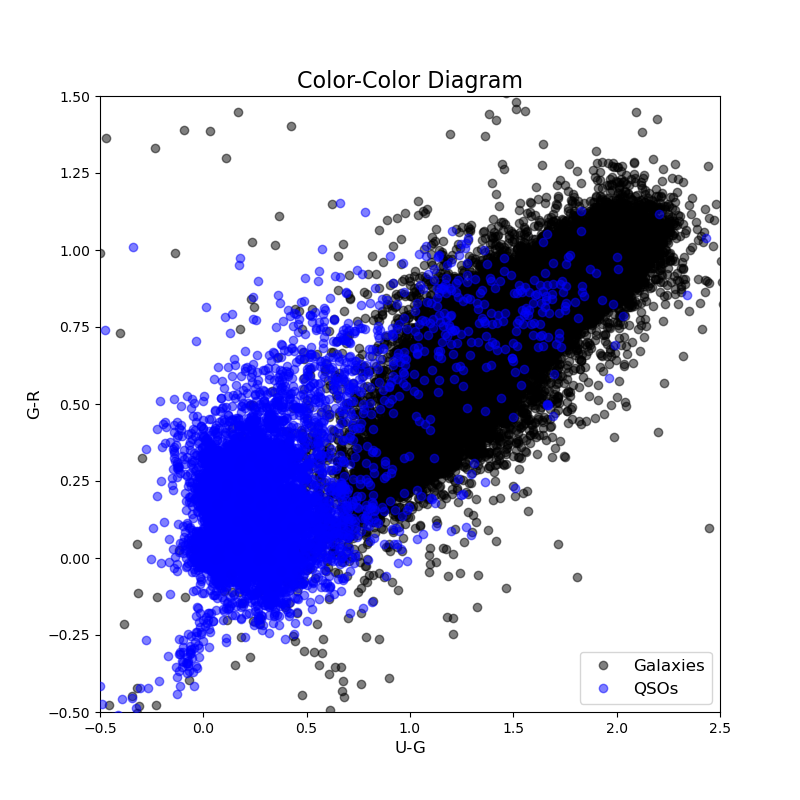

In [106]:
# Creating the graph (interactive style)
%matplotlib widget 
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

# Making the masks for all the data points
galaxy_mask = specClass == 'GALAXY'
qso_mask = specClass == 'QSO'

# Plotting the galaxy data points
ax.plot(u_g[galaxy_mask], g_r[galaxy_mask], color='black', 
        zorder=15, linestyle='none', 
        marker='o', alpha=0.5, label='Galaxies')

# Plotting the quasar data points
ax.plot(u_g[qso_mask], g_r[qso_mask], color='blue', 
        zorder=15, linestyle='none', 
        marker='o', alpha=0.5, label='QSOs')

# Adding labels and title
ax.set_xlabel('U-G', fontsize=12)
ax.set_ylabel('G-R', fontsize=12)
ax.legend(loc='lower right', fontsize=12)
ax.set_title('Color-Color Diagram', fontsize=16)
ax.set_xlim(-0.5, 2.5)
ax.set_ylim(-0.5, 1.5)


## <font color='green'>**PART THREE!**</font>

<font color='orange'>Stack all colors and the redshift into a data matrix, $X$. Create a target label array that has $0$ for a regular galaxy and $1$ for a quasar. Perform a train-test split, taking $20\%$ of the data for testing.</font>

First thing's first, I have to properly manage the data array. I am creating an array with all the different lettered colors, and then also the redshift.

In [107]:
X = np.vstack((data['u'], data['g'], data['r'], data['i'], data['z'], data['redshift'])).T

Now, we must also construct the labels we will be using. Here's how I did it:

In [108]:
y = np.where(data['specClass'] == 'GALAXY', 0, 1)  # 0 = Galaxy, 1 = QSO

Now, let's create the train/test split, using the module from sklearn!

In [109]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Here are the shapes of each array:

In [110]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(40000, 6) (10000, 6)
(40000,) (10000,)


## <font color='green'>**PART FOUR!**</font>

<font color='orange'>Create a compact `for` loop that iterates over the fitting of a Gaussian Naive Bayes classification algorithm to successively more features of the data. Within the loop, compute and plot an ROC curve. The end result should be a plot showing ROC curves for GNB classification with more and more features of the data, with appropriate axis labels and a legend. Use `xlim` between 0 and 0.01. Which feature seems to make the classification trivially easy? *Note: `predict_proba` returns an array with as many columns as classes. You've labeled quasars as $1$, so for the ROC curve you must make sure to access the relevant quasar probability-- you can find this by accessing the **classes_** attribute of the estimator.*</font>

For these next few steps, since they are often repeats of each other but with different models, I will be keeping everything in one block while explaining a little more in the comments.

X has shape (n_samples, 6) and y has points 0 (galaxy) or 1 (quasar). We want to compare ROC curves for different Gaussian Naive Bayes models with differing amounts of features from the original graph (five colors and redshift). In the for-loop, we restrict the size of X based on the counter, train the GNB on that subset of X, predict the probabilities, and then compare with the actual data to see how well it worked (false positive/true positive rate), constructing ROC curves and finishing out. From this, it looks like using all six features was the best idea! Interesting!

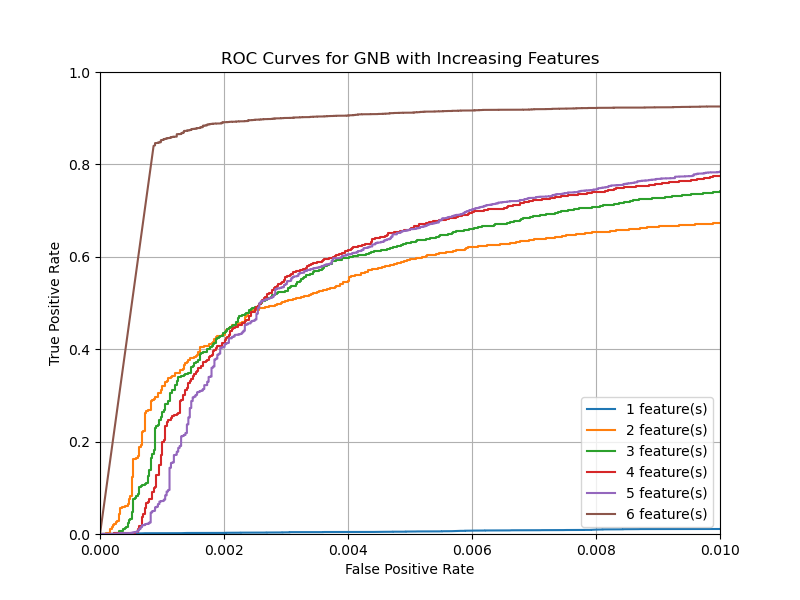

In [111]:
plt.figure(figsize=(8, 6))

# For-loop constructing all the graphs
for i in range(1, X.shape[1] + 1):  # from 1 to 6 features
    X_subset = X[:, :i]  # use first i features each time

    # Training GNB model
    model = GaussianNB()
    model.fit(X_subset, y)

    # Predicted probabilities
    y_prob = model.predict_proba(X_subset)

    # Column indices for quasar (label 1)
    quasar_index = list(model.classes_).index(1)
    
    # Computing ROC
    fpr, tpr, _ = metrics.roc_curve(y, y_prob[:, quasar_index])

    # Plot
    plt.plot(fpr, tpr, label=f'{i} feature(s)')

# Formatting
plt.xlim(0, 0.01)
plt.ylim(0, 1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for GNB with Increasing Features")
plt.legend()
plt.grid(True)
plt.show()


## <font color='green'>**PART FIVE!**</font>

<font color='orange'>Repeat (4) for Quadratic Discriminant Analysis.</font>

Now, we do the same here. Restrict X based on number of features wanted, train the subset on a QDA model, predict the probabilities, and compare to the actual data to construct an ROC curve:

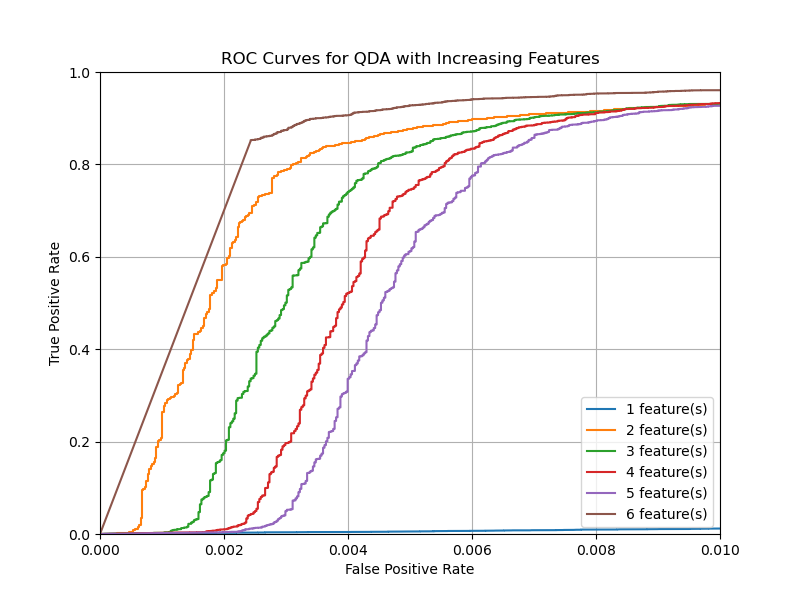

In [112]:
plt.figure(figsize=(8, 6))

# For-loop constructing all the graphs
for i in range(1, X.shape[1] + 1):  # from 1 to 6 features
    X_subset = X[:, :i]  # use first i features each time

    # Training QDA model
    model = QuadraticDiscriminantAnalysis()
    model.fit(X_subset, y)

    # Predicted probabilities
    y_prob = model.predict_proba(X_subset)

    # Column indices for quasar (label 1)
    quasar_index = list(model.classes_).index(1)
    
    # Computing ROC
    fpr, tpr, _ = metrics.roc_curve(y, y_prob[:, quasar_index])

    # Plot
    plt.plot(fpr, tpr, label=f'{i} feature(s)')

# Formatting
plt.xlim(0, 0.01)
plt.ylim(0, 1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for QDA with Increasing Features")
plt.legend()
plt.grid(True)
plt.show()

## <font color='green'>**PART SIX!**</font>

<font color='orange'>Let's try classification with GMM Bayes. Restrict the training and testing to be just on the $4$ colors. Iterate now over number of components in the GMM Bayes fit up to $10$, plotting ROC curves for all, and find the number of components that gives the best performance.</font>

This time, we are switching up the model a little bit. Since GMMBayes varies depending on the number of components as well as colors, we test the change over ten total components with four colors. We iterate from one to ten components in our model, and plot the ROC curves from there:

/Users/blakeghg/miniconda3/envs/astr8070/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/Users/blakeghg/miniconda3/envs/astr8070/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/Users/blakeghg/miniconda3/envs/astr8070/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/Users/blakeghg/miniconda3/envs/astr8070/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check fo

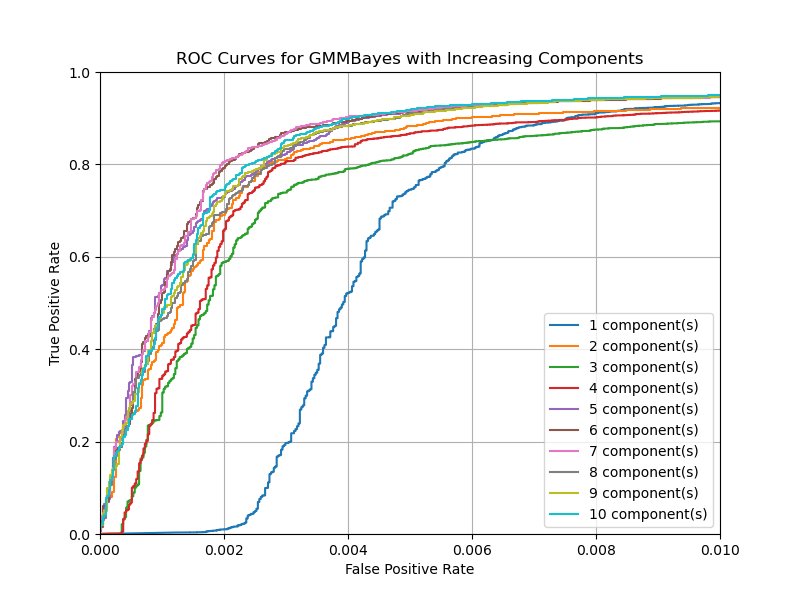

In [113]:
plt.figure(figsize=(8, 6))

# For-loop constructing all the graphs
for i in range(1, 11):  # from 1 to 10 components
    X_subset = X[:, :4]  # use first 4 features

    # Training GMMBayes model
    model = GMMBayes(n_components=i, tol=1E-5, covariance_type='full')
    model.fit(X_subset, y)

    # Predicted probabilities
    y_prob = model.predict_proba(X_subset)

    # Column indices for quasar (label 1)
    quasar_index = list(model.classes_).index(1)
    
    # Computing ROC
    fpr, tpr, _ = metrics.roc_curve(y, y_prob[:, quasar_index])

    # Plot
    plt.plot(fpr, tpr, label=f'{i} component(s)')

# Formatting
plt.xlim(0, 0.01)
plt.ylim(0, 1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for GMMBayes with Increasing Components")
plt.legend()
plt.grid(True)
plt.show()

## <font color='green'>**PART SEVEN!**</font>

<font color='orange'>Repeat (6) for $K$-nearest neighbor classification, looping over number of neighbors between 5 and 100 in steps of 10. Find the number that gives the best performance. </font>

Now, we do the same thing as before, on the first four colors, but iterating between 5 and 100 in steps of 10. This is because we are feeding the KNN model the amount of neighbors it requires to do its analysis. We go as so:

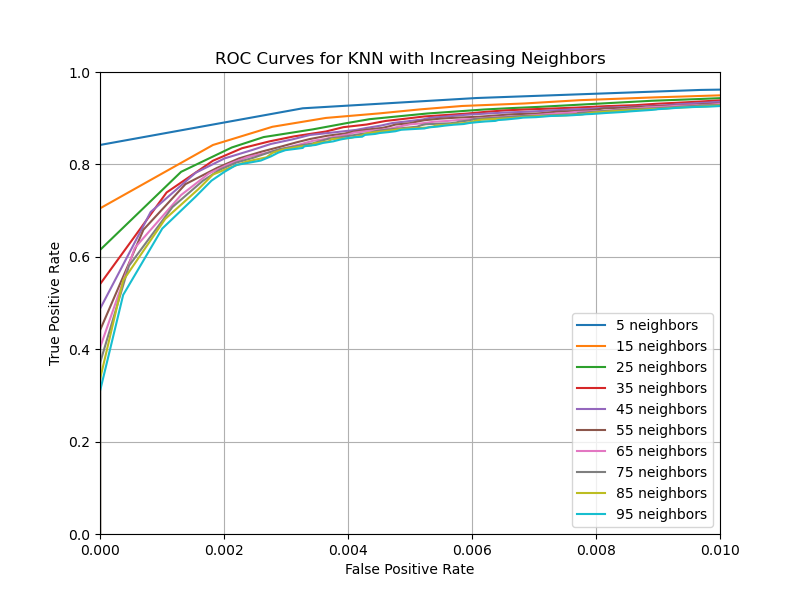

In [114]:
plt.figure(figsize=(8, 6))

for i in range(5, 100, 10):  # from 5 to 95 neighbors, in steps of 10
    X_subset = X[:, :4]  # use first 4 features

    # Training KNeighborsClassifier model
    model = KNeighborsClassifier(n_neighbors=i)
    model.fit(X_subset, y)

    # Predicted probabilities
    y_prob = model.predict_proba(X_subset)

    # Column indices for quasar (label 1)
    quasar_index = list(model.classes_).index(1)
    
    # Computing ROC
    fpr, tpr, _ = metrics.roc_curve(y, y_prob[:, quasar_index])

    # Plot
    plt.plot(fpr, tpr, label=f'{i} neighbors')

# Formatting
plt.xlim(0, 0.01)
plt.ylim(0, 1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for KNN with Increasing Neighbors")
plt.legend()
plt.grid(True)
plt.show()

## <font color='green'>**PART EIGHT!**</font>

<font color='orange'>Repeat (6) for Decision Tree classification, looping over the maximum tree depth between 1 and 10. Find the number that gives the best performance.  </font>

Here, we now iterate from 1 to 10 again, but this time measuring the depth of our decision tree model each time:

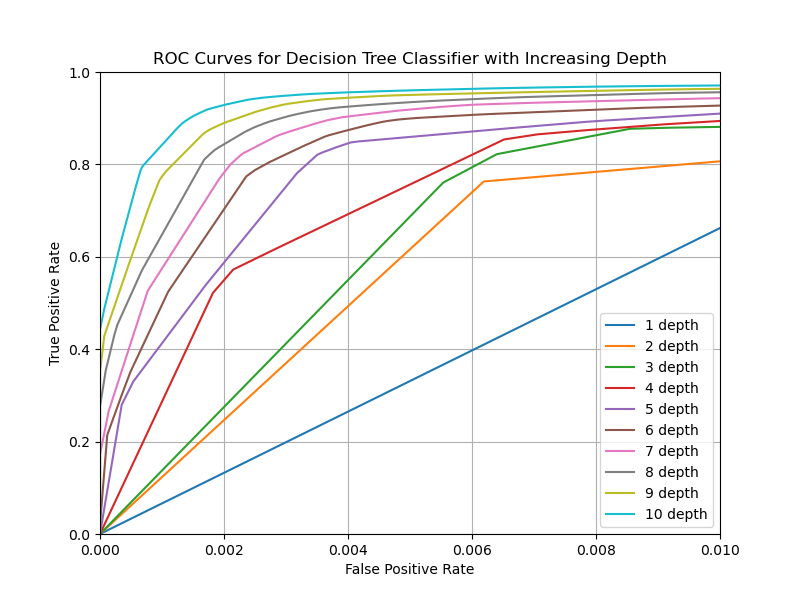

In [115]:
plt.figure(figsize=(8, 6))

# For-loop constructing all the graphs
for i in range(1, 11):  # from 1 to 10 depth
    X_subset = X[:, :4]  # use first 4 features

    # Training DecisionTreeClassifier model
    model = DecisionTreeClassifier(max_depth=i, criterion='entropy') # Big fan of Claude Shannon!
    model.fit(X_subset, y)

    # Predicted probabilities
    y_prob = model.predict_proba(X_subset)

    # Column indices for quasar (label 1)
    quasar_index = list(model.classes_).index(1)
    
    # Computing ROC
    fpr, tpr, _ = metrics.roc_curve(y, y_prob[:, quasar_index])

    # Plot
    plt.plot(fpr, tpr, label=f'{i} depth')

# Formatting
plt.xlim(0, 0.01)
plt.ylim(0, 1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Decision Tree Classifier with Increasing Depth")
plt.legend()
plt.grid(True)
plt.show()

## <font color='green'>**PART NINE!**</font>

<font color='orange'>Finally, plot the ROC curves for GNB, QDA, and the best-performing GMMBayes, KNN, and DT classification algorithms, all using just the 4 colors. What is the overall best-performing classifier?   </font>

First thing's first, I am going to define all of the best values from all the earlier stages that were the best (by my inspection):

In [116]:
best_k = 5 # KNN
best_depth = 10  # Decision Tree
best_n_components = 7 # GMMBayes

Also, we are going to restrict the X array to just the first four colors for EVERYTHING:

In [117]:
X_colors = X[:, :4]

I am going to create a helper function to plot the ROC curves for everything, and also calculate the AUC (because inspection only goes so far) to figure out which model deserves the crown!

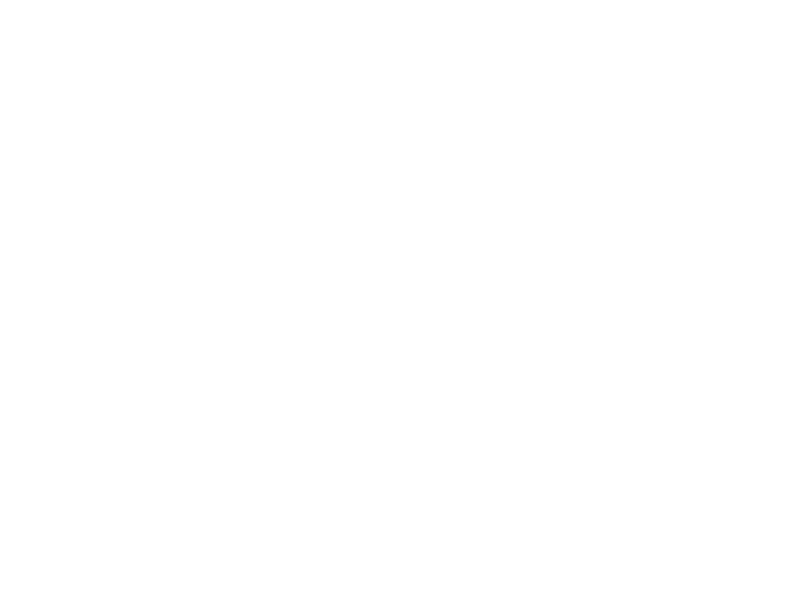

In [118]:
# Starting the plotting process
%matplotlib widget 
plt.figure(figsize=(8, 6))

# Helper to plot ROC curve
def plot_model_roc(model, X, y, label):
    y_prob = model.predict_proba(X)
    quasar_index = list(model.classes_).index(1)
    fpr, tpr, _ = metrics.roc_curve(y, y_prob[:, quasar_index])
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc:.2f})")

Now, I am going to define ALL the models and plot them here. The GNB, QDA, KNN (k=5), Decision Tree (depth=10), and GMMBayes (components=7).

/Users/blakeghg/miniconda3/envs/astr8070/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/Users/blakeghg/miniconda3/envs/astr8070/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


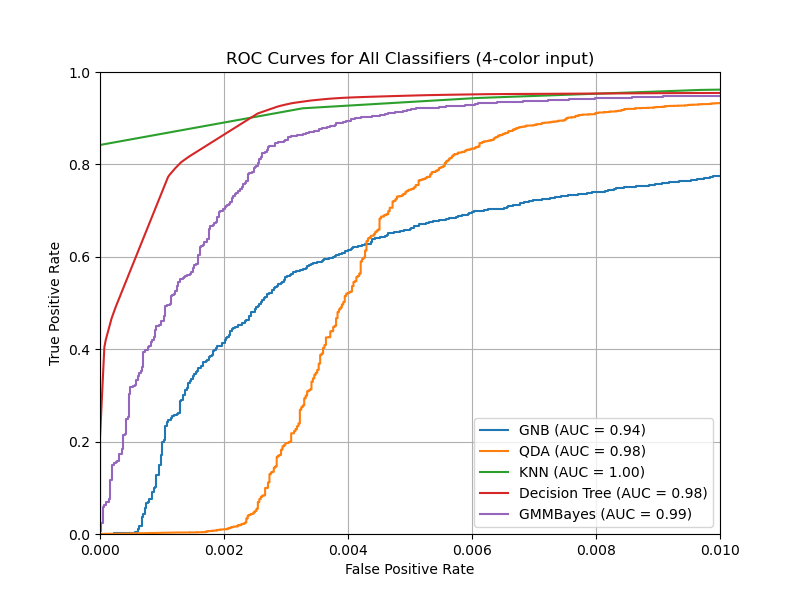

In [119]:
# 1. GNB
gnb = GaussianNB().fit(X_colors, y)
plot_model_roc(gnb, X_colors, y, "GNB")

# 2. QDA
qda = QuadraticDiscriminantAnalysis().fit(X_colors, y)
plot_model_roc(qda, X_colors, y, "QDA")

# 3. KNN
knn = KNeighborsClassifier(n_neighbors=best_k).fit(X_colors, y)
plot_model_roc(knn, X_colors, y, "KNN")

# 4. Decision Tree
dt = DecisionTreeClassifier(max_depth=best_depth).fit(X_colors, y)
plot_model_roc(dt, X_colors, y, "Decision Tree")

# 5. GMMBayes
model = GMMBayes(n_components=i, tol=1E-5, covariance_type='full').fit(X_colors, y)
plot_model_roc(model, X_colors, y, "GMMBayes")

# Final plot formatting
plt.xlim(0, 0.01)
plt.ylim(0, 1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for All Classifiers (4-color input)")
plt.legend()
plt.grid(True)
plt.show()

We have a winner!! Go KNN!!

## <font color='green'>**PART TEN!**</font>

<font color='orange'>Make a 2-panel plot, showing in the left panel the color-coded training data in $(u-g)$ versus $(g-r)$ (similar to item 2 above), and in the right panel the same features of the testing data color coded by their predicted class from the tuned best-performing classifier. </font>

In order to show this thing off, we can start by collecting all the colors from the training data. However, we need to restrict the training data to just the first four features so my KNN does not explode (which is very rude!!!). ANyways, here's how I did it:

In [125]:
X_colors_test = X_test[:, :4]
X_colors_train = X_train[:, :4]

BOOM!! We are SO back! Let's split up all the color data:

In [126]:
u_train = X_colors_train[:, 0]
g_train = X_colors_train[:, 1]
r_train = X_colors_train[:, 2]

In [127]:
u_test = X_colors_test[:, 0]
g_test = X_colors_test[:, 1]
r_test = X_colors_test[:, 2]

Here, we create the color features:

In [128]:
ug_train = u_train - g_train
gr_train = g_train - r_train

In [129]:
ug_test = u_test - g_test
gr_test = g_test - r_test

For the winning KNN model, let's predict the classes (LABELS, not probabilities):

In [140]:
y_pred = knn.predict(X_colors_test)

In [147]:
y_pred.shape

(10000,)

Here, I make the masks!

In [142]:
y_pred_quasar = y_pred == 1
y_pred_galaxy = y_pred == 0

Finally, let's plot the two panels! We mask each with their appropriate indicated values (left is the training data masked with the true labels, and the right is the testing data masked with the predicted labels). With that, here's the final result:

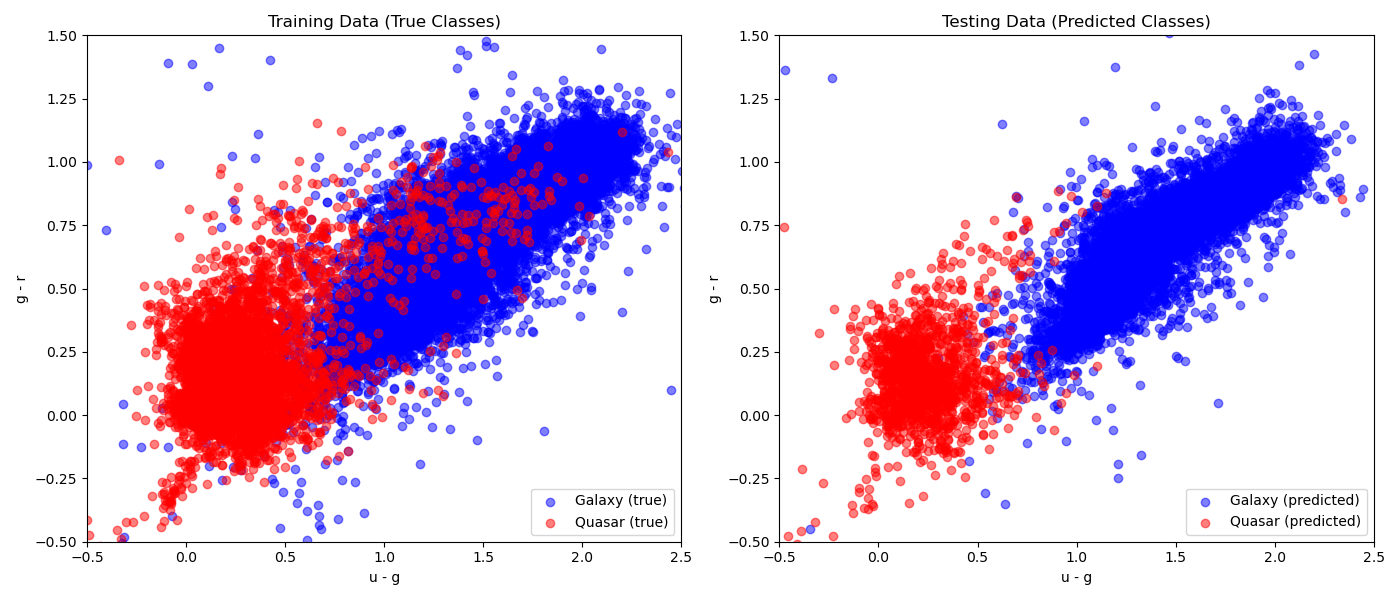

In [143]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Left panel: training data with true labels
ax1.scatter(ug_train[y_train == 0], gr_train[y_train == 0], color='blue', alpha=0.5, label='Galaxy (true)')
ax1.scatter(ug_train[y_train == 1], gr_train[y_train == 1], color='red', alpha=0.5, label='Quasar (true)')
ax1.set_title("Training Data (True Classes)")
ax1.set_xlabel("u - g")
ax1.set_ylabel("g - r")
ax1.set_xlim(-0.5, 2.5)
ax1.set_ylim(-0.5, 1.5)
ax1.legend()

# Right panel: testing data with predicted labels
ax2.scatter(ug_test[y_pred_galaxy], gr_test[y_pred_galaxy], color='blue', alpha=0.5, label='Galaxy (predicted)')
ax2.scatter(ug_test[y_pred_quasar], gr_test[y_pred_quasar], color='red', alpha=0.5, label='Quasar (predicted)')
ax2.set_title("Testing Data (Predicted Classes)")
ax2.set_xlabel("u - g")
ax2.set_ylabel("g - r")
ax2.set_xlim(-0.5, 2.5)
ax2.set_ylim(-0.5, 1.5)
ax2.legend()

plt.tight_layout()
plt.show()


Not a bad correspondence! Still a bit of weird overlap on the first and not as much the second, but still looking pretty nice!

# <font color='green'>**PROBLEM TWO!**</font>

## <font color='green'>**PART ONE!**</font>

<font color='orange'>Read in the same galaxy color data used above. Slice the data array to only take every other 10th row. From this reduced data volume, create arrays of $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create arrays of redshift and the spectral class. </font>

Alright! Let's start going crazy! First step is to make the dataset skip every ten rows:

In [144]:
data_every_10_rows = data[::10]  # Select every 10th row

Checking that it actually did its job:

In [145]:
data.shape

(50000,)

In [146]:
data_every_10_rows.shape

(5000,)

Nice! Now, let's split this new dataset into its individual colors!

In [148]:
u_g_10 = data_every_10_rows['u'] - data_every_10_rows['g']
g_r_10 = data_every_10_rows['g'] - data_every_10_rows['r']
r_i_10 = data_every_10_rows['r'] - data_every_10_rows['i']
i_z_10 = data_every_10_rows['i'] - data_every_10_rows['z']

Here are the arrays for the redshift adn spectral classess again for this new dataset:

In [149]:
redshift_10 = data_every_10_rows['redshift']
specClass_10 = data_every_10_rows['specClass']

Finally, here are the new counts!

In [150]:
num_galaxies_10 = np.sum(specClass_10 == 'GALAXY')
num_quasars_10 = np.sum(specClass_10 == 'QSO')

print(f"Number of regular galaxies: {num_galaxies_10}")
print(f"Number of quasars: {num_quasars_10}")

Number of regular galaxies: 4264
Number of quasars: 736


## <font color='green'>**PART TWO!**</font>

<font color='orange'>We're going to make classification pretty tough for our deep neural network. Make a scatter plot of $(r-i)$ versus $(i-z)$, color coding by galaxy or quasar class. Notice how much more difficult the visual discrimination is compared to $(u-g)$ versus $(g-r)$. The plot should include appropriate axis labels and a legend.</font>

Alright! First, to prepare for the difficult deep learning road ahead, we will first start with recreating the plot from above, except for different colors (r-i and i-z this time). Here's my go at it:

(-0.5, 1.5)

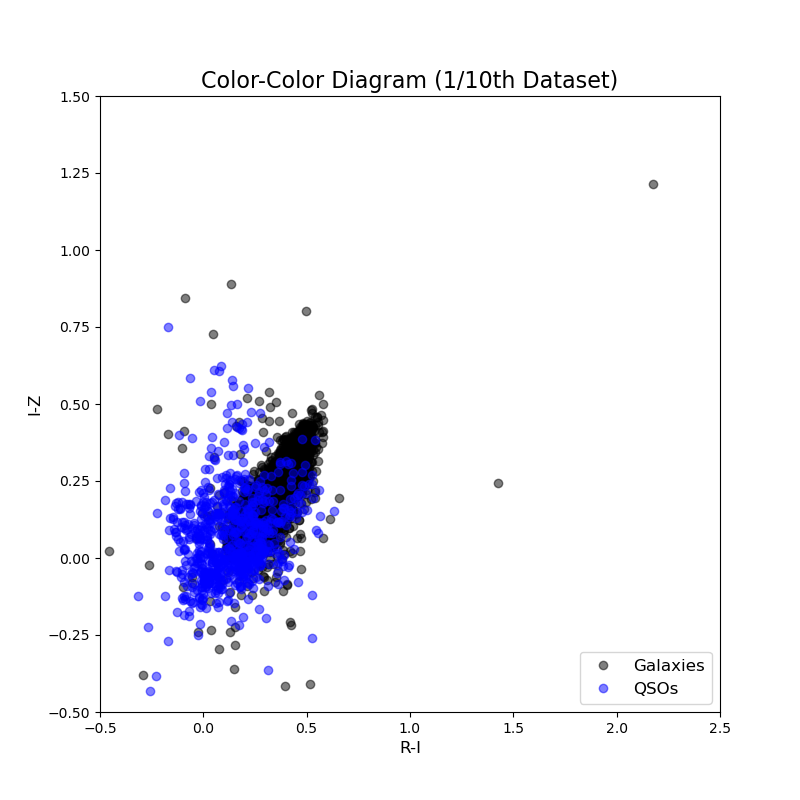

In [151]:
# Creating the graph (again) (interactive style)
%matplotlib widget 
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

# Making the masks for all the data points
galaxy_mask_10 = specClass_10 == 'GALAXY'
qso_mask_10 = specClass_10 == 'QSO'

# Plotting the galaxy data points
ax.plot(r_i_10[galaxy_mask_10], i_z_10[galaxy_mask_10], color='black', 
        zorder=15, linestyle='none', 
        marker='o', alpha=0.5, label='Galaxies')

# Plotting the quasar data points
ax.plot(r_i_10[qso_mask_10], i_z_10[qso_mask_10], color='blue', 
        zorder=15, linestyle='none', 
        marker='o', alpha=0.5, label='QSOs')

# Adding labels and title
ax.set_xlabel('R-I', fontsize=12)
ax.set_ylabel('I-Z', fontsize=12)
ax.legend(loc='lower right', fontsize=12)
ax.set_title('Color-Color Diagram (1/10th Dataset)', fontsize=16)
ax.set_xlim(-0.5, 2.5)
ax.set_ylim(-0.5, 1.5)

## <font color='green'>**PART THREE!**</font>

<font color='orange'>Stack the $(r-i)$ and $(i-z)$ colors into a data matrix, $X$. Create a target label array that has $0$ for a regular galaxy and $1$ for a quasar. Perform a train-test split, taking $20\%$ of the data for testing. Set the `random_state` in your train-test split to be `42` for reproducibility (and easy comparison with my solutions).</font>

Now, we repeat the creation of X and the train/test split, but this time ONLY with the r-i and i-z colors. Let's start with X:

In [152]:
X_10 = np.vstack((r_i_10, i_z_10)).T

And now, y, again:

In [153]:
y_10 = np.where(specClass_10 == 'GALAXY', 0, 1)  # 0 = Galaxy, 1 = QSO


Let's do the train/test split!

In [154]:
X_train_10, X_test_10, y_train_10, y_test_10 = train_test_split(X_10, y_10, test_size=0.2, random_state=42)

Here are the final shapes:

In [155]:
print(X_train_10.shape, X_test_10.shape)
print(y_train_10.shape, y_test_10.shape)

(4000, 2) (1000, 2)
(4000,) (1000,)


## <font color='green'>**PART FOUR!**</font>

<font color='orange'>Scale your training and testing data to prepare it for the DNN. </font>

Alright! Following along with the process in lecture 21, I scale the data using the sklearn preprocessing package:

In [156]:
X_train_scaled_10 = preprocessing.scale(X_train_10)
X_test_scaled_10 = preprocessing.scale(X_test_10)
X_scaled_10 = preprocessing.scale(X_10)

Done!

## <font color='green'>**PART FIVE!**</font>

<font color='orange'>Train scikit-learn's multi-layer perceptron classifier with ReLU activation, stochastic gradient descent, two hidden layers of respective sizes of $5$ and $2$, and using `max_iter=1000`, and `random_state=42`. As with classifiers in last week's homework, plot an ROC curve that shows the network's performance on the scaled testing data.</font>

Here, I will construct the multi-layer perceptron classifier (MLPClassifier) before your very eyes! We use a stochastic gradient descent (sgd) solver, a ReLU activation function, two hidden layers of size 5 and 2 respectively, a maximum iteration size of 1000, and the random state 42 (for cross checking):

In [157]:
clf = MLPClassifier(solver='sgd', activation='relu', hidden_layer_sizes=(5, 2), random_state=42, max_iter=1000)

Now, we do the fit:

In [158]:
clf.fit(X_train_scaled_10, y_train_10)

MLPClassifier(hidden_layer_sizes=(5, 2), max_iter=1000, random_state=42,
              solver='sgd')

Let's predict the class probabilities:

In [159]:
y_prob = clf.predict_proba(X_test_scaled_10)
quasar_index = list(clf.classes_).index(1)

Now, let's finish out with the ROC curve:

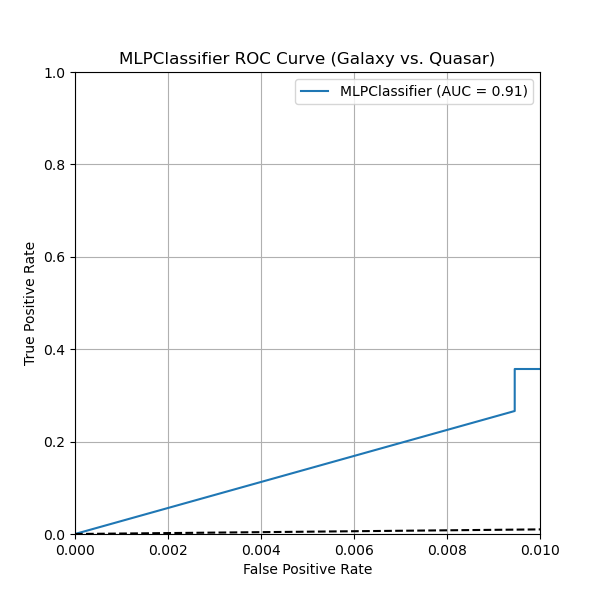

In [160]:
# ROC curve
fpr, tpr, _ = roc_curve(y_test_10, y_prob[:, quasar_index])
roc_auc = auc(fpr, tpr)

# Plotting ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"MLPClassifier (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')  # random baseline
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("MLPClassifier ROC Curve (Galaxy vs. Quasar)")
plt.xlim(0, 0.01)
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.show()

Okay, wow, not really that impressive, huh? Let's try some optimization next. See if we can make this thing any better.

## <font color='green'>**PART SIX!**</font>

<font color='orange'>Now let's optimize the hyperparameters of your network. You will use `GridSearchCV` with the following hyperparameters for the network:

```
parameters = {'solver': ['lbfgs', 'sgd', 'adam'], 
              'hidden_layer_sizes': [(2,2), (5,5), (5,2), (5,5,5)], 
              'activation': ['relu', 'tanh'], 
              'random_state': [42], 'max_iter': [1000]}
```

Remember that you can utilize all availables cores on your machine with `n_jobs=-1`. Print out the classification score for the training data, and the best parameters obtained by the cross validation.</font>

Alright. Let's make some magic! First, we start with the parameters listed that we want to test over:

In [161]:
parameters = {
    'solver': ['lbfgs', 'sgd', 'adam'],
    'hidden_layer_sizes': [(2,2), (5,5), (5,2), (5,5,5)],
    'activation': ['relu', 'tanh'],
    'random_state': [42],
    'max_iter': [1000]
}

Now, we conduct the grid search over all these parameters:

In [162]:
grid_search = GridSearchCV(
    MLPClassifier(),
    parameters,
    scoring='roc_auc', 
    n_jobs=-1,          # Use all cores on my 'puter
    cv=5                # 5-fold cross-validation bc why not
)

The fit for all of this is done here:

In [163]:
grid_search.fit(X_train_scaled_10, y_train_10)

/Users/blakeghg/miniconda3/envs/astr8070/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/blakeghg/miniconda3/envs/astr8070/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/blakeghg/miniconda3/envs/astr8070/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541

GridSearchCV(cv=5, estimator=MLPClassifier(), n_jobs=-1,
             param_grid={'activation': ['relu', 'tanh'],
                         'hidden_layer_sizes': [(2, 2), (5, 5), (5, 2),
                                                (5, 5, 5)],
                         'max_iter': [1000], 'random_state': [42],
                         'solver': ['lbfgs', 'sgd', 'adam']},
             scoring='roc_auc')

Finally, I tell you which model from the parameters is best:

In [164]:
print("Best hyperparameters:", grid_search.best_params_)
print("Training set score:", grid_search.best_estimator_.score(X_train_scaled_10, y_train_10))
print("Testing set score:", grid_search.best_estimator_.score(X_test_scaled_10, y_test_10))

Best hyperparameters: {'activation': 'tanh', 'hidden_layer_sizes': (5, 5, 5), 'max_iter': 1000, 'random_state': 42, 'solver': 'adam'}
Training set score: 0.9355
Testing set score: 0.919


## <font color='green'>**PART SEVEN!**</font>

<font color='orange'>Fit a new DNN using the best hyperparameters obtained in (6), and make a plot that has ROC curves for this new network and your original network. Let the x and y axes have the full limit range of 0 to 1. Voila!</font>

To finish this out, we first start with getting the best model from the grid_search:

In [165]:
best_model = grid_search.best_estimator_

Predict classes again:

In [166]:
y_prob = best_model.predict_proba(X_test_scaled_10)
quasar_index = list(best_model.classes_).index(1)

And plot the ROC curve! Voila!! We are done!!

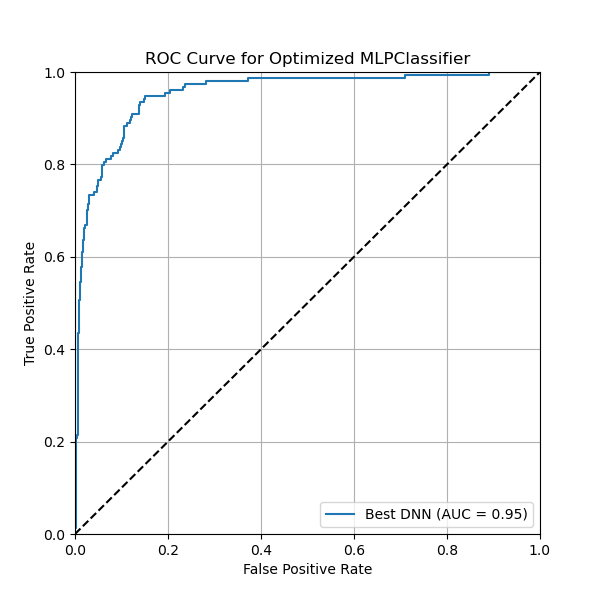

In [167]:
# ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test_10, y_prob[:, quasar_index])
roc_auc = auc(fpr, tpr)

# Plotting ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"Best DNN (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')  # Random baseline bc it looks nice
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Optimized MLPClassifier")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.show()


That's a LOT better!!!!

With that, I finish out my homeworks for the year! Thanks for everything, big man!